# ✅ Импорты

In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklift.models import SoloModel
from sklift.models import TwoModels
from sklift.metrics import uplift_at_k
from sklift.datasets import fetch_hillstrom

from causalml.inference.meta.slearner import BaseSClassifier as CausalSoloModel
from causalml.inference.meta.tlearner import BaseTClassifier as CausalTwoModels

from upninja.pipelines import DataTransformers
from upninja.pipelines import BasePipeline
from upninja.utils.Score import upliftComparingHist, scoreUpliftAtK

import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Загрузка и обработка Kevin Hillstrom датасета

In [2]:
data = fetch_hillstrom()
X, y, t = data['data'], data['target'], data['treatment']
# упростим целевую группу - сократим до была рассылка/не было рассылки
t = t.map({'Womens E-Mail':1, 'Mens E-Mail':1, 'No E-Mail':0})

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, 
                                                                     y, t, 
                                                                     test_size=0.3, 
                                                                     random_state=42)

# ✅ Протестируем Scikit-uplifts

In [3]:
s_learner_model = SoloModel(CatBoostClassifier(logging_level='Silent'))

s_learner_pipeline = BasePipeline.BasePipeline([
    ('hilstrom-transformer', DataTransformers.HillstromTransformer()),
    ('slearner', s_learner_model)
])

In [4]:
%%time

s_learner_pipeline.fit(X_train, y_train, t_train)

CPU times: user 25.1 s, sys: 1.8 s, total: 26.9 s
Wall time: 7.43 s


,steps,"[('hilstrom-transformer', ...), ('slearner', ...)]"


In [5]:
two_models_model = TwoModels(
    CatBoostClassifier(logging_level='Silent'),
    CatBoostClassifier(logging_level='Silent'),
    method='vanilla'
)

two_models_pipeline = BasePipeline.BasePipeline([
    ('hilstrom-transformer', DataTransformers.HillstromTransformer()),
    ('two-models', two_models_model)
])

In [6]:
%%time

two_models_pipeline.fit(X_train, y_train, t_train)

CPU times: user 30.3 s, sys: 2.73 s, total: 33.1 s
Wall time: 9.29 s


,steps,"[('hilstrom-transformer', ...), ('two-models', ...)]"


In [7]:
models_w_preds = (
    ('s-learner', s_learner_pipeline.predict(X_test)),
    ('two-models', two_models_pipeline.predict(X_test))
)

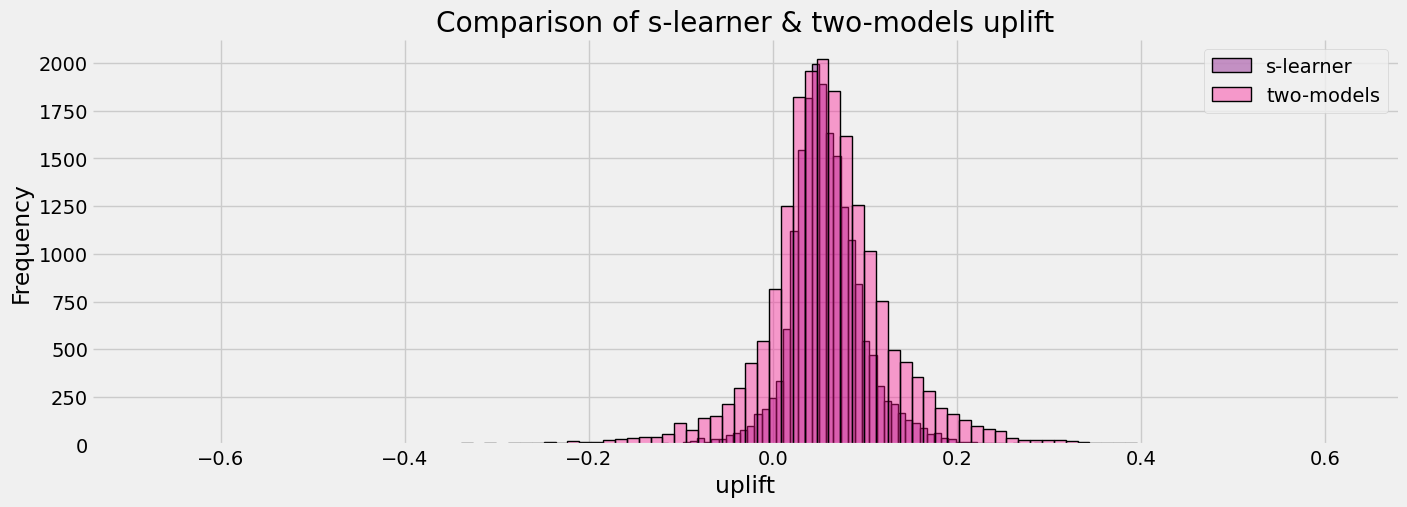

In [8]:
res = upliftComparingHist(
    model_name_1=models_w_preds[0][0],
    model_predictions_1=models_w_preds[0][1],
    model_name_2=models_w_preds[1][0],
    model_predictions_2=models_w_preds[1][1]
)

In [9]:
scoreUpliftAtK(
    models_w_preds,
    y_test,
    t_test
)

{'s-learner': 0.0841, 'two-models': 0.0835}

# ✅ Протестируем Causal-ML

In [10]:
s_learner_model = CausalSoloModel(CatBoostClassifier(logging_level='Silent'))

s_learner_pipeline = BasePipeline.BasePipeline([
    ('hilstrom-transformer', DataTransformers.HillstromTransformer()),
    ('slearner', s_learner_model)
])

In [11]:
%%time

s_learner_pipeline.fit(X_train, y_train, t_train)

CPU times: user 25.6 s, sys: 1.8 s, total: 27.4 s
Wall time: 7.68 s


,steps,"[('hilstrom-transformer', ...), ('slearner', ...)]"


In [12]:
two_models_model = CausalTwoModels(
    CatBoostClassifier(logging_level='Silent'),
    CatBoostClassifier(logging_level='Silent')
)

two_models_pipeline = BasePipeline.BasePipeline([
    ('hilstrom-transformer', DataTransformers.HillstromTransformer()),
    ('two-models', two_models_model)
])

In [13]:
%%time

two_models_pipeline.fit(X_train, y_train, t_train)

CPU times: user 29.6 s, sys: 3.16 s, total: 32.8 s
Wall time: 9.39 s


,steps,"[('hilstrom-transformer', ...), ('two-models', ...)]"


In [14]:
models_w_preds = (
    ('s-learner', s_learner_pipeline.predict(X_test).flatten()),
    ('two-models', two_models_pipeline.predict(X_test).flatten())
)

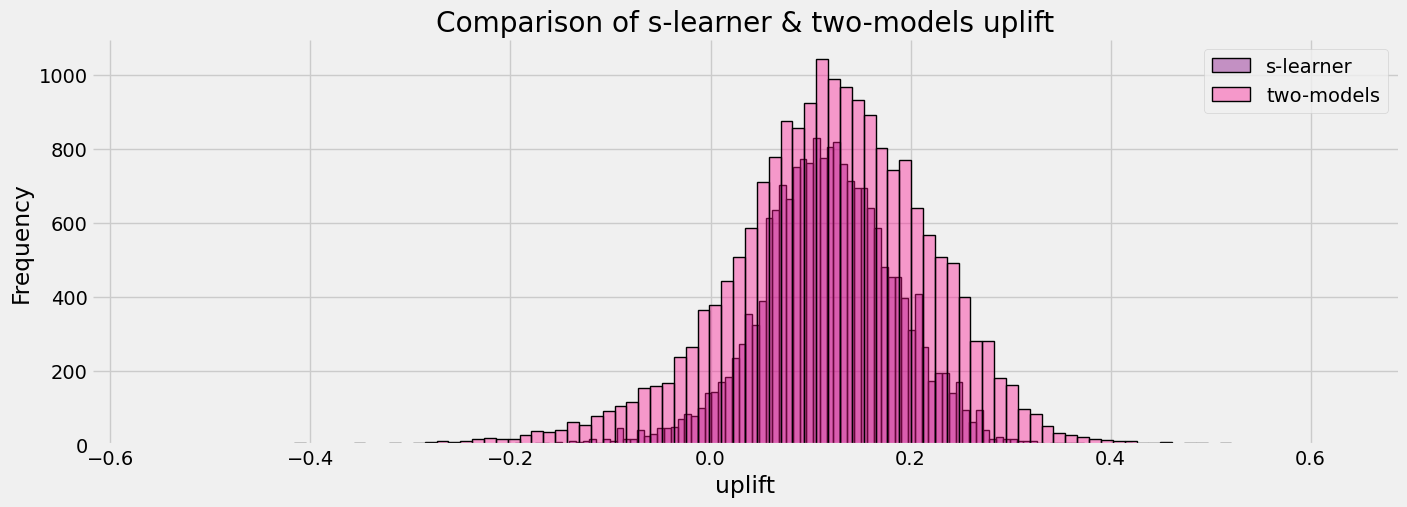

In [15]:
res = upliftComparingHist(
    model_name_1=models_w_preds[0][0],
    model_predictions_1=models_w_preds[0][1],
    model_name_2=models_w_preds[1][0],
    model_predictions_2=models_w_preds[1][1]
)

In [16]:
scoreUpliftAtK(
    models_w_preds,
    y_test,
    t_test
)

{'s-learner': 0.0629, 'two-models': 0.0565}